In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [239]:
data = pd.read_csv('train.csv', index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
data[data['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [5]:
data.query('Embarked == "C"').describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,168.000000,168.000000,130.000000,168.000000,168.000000,168.000000
mean,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
std,0.498608,0.944100,15.434860,0.557213,0.660481,83.912994
min,0.000000,1.000000,0.420000,0.000000,0.000000,4.012500
25%,0.000000,1.000000,21.250000,0.000000,0.000000,13.697950
50%,1.000000,1.000000,29.000000,0.000000,0.000000,29.700000
75%,1.000000,3.000000,40.000000,1.000000,1.000000,78.500025
max,1.000000,3.000000,71.000000,2.000000,3.000000,512.329200


In [6]:
data['Embarked'] = data['Embarked'].fillna('C')

In [12]:
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [51]:
data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [13]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [14]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

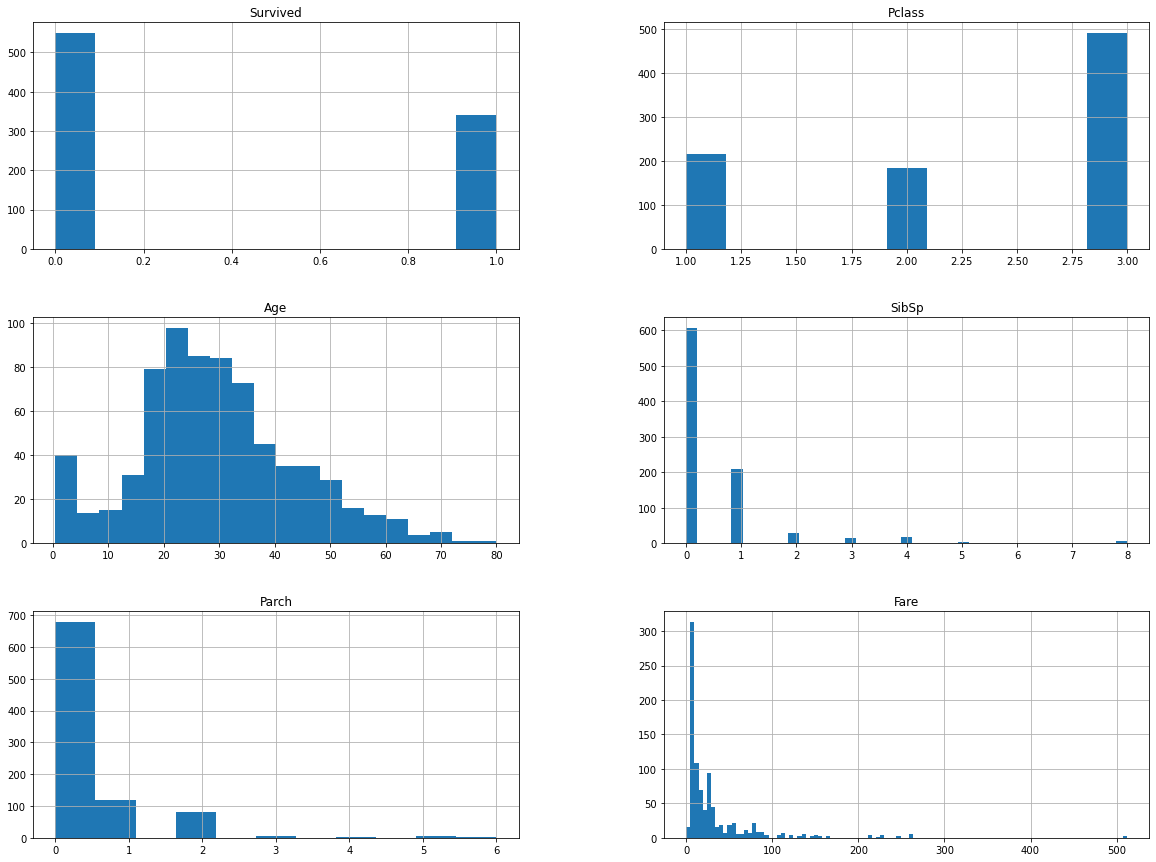

In [17]:
data.hist(bins='auto', figsize=(20,15))

In [20]:
np.corrcoef(data['Pclass'].values, data['Survived'].values)

array([[ 1.        , -0.33848104],
       [-0.33848104,  1.        ]])

In [46]:
y = data['Survived'].values
num = ['Age', 'SibSp', 'Parch', 'Fare']
cat = ['Pclass', 'Sex', 'Embarked']

In [47]:
num_pipe = Pipeline([('imputer', SimpleImputer(strategy="mean")),
                     ('scaler', StandardScaler())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', OneHotEncoder(), cat)])

In [85]:
X = prep_pipe.fit_transform(data)

In [59]:
clf_pipe = Pipeline([('preparation', prep_pipe),
                     ('clf', LogisticRegression())])

In [67]:
grid_clf = GridSearchCV(clf_pipe, {'clf': [LogisticRegression(),
                                           SVC(),
                                           DecisionTreeClassifier(), 
                                           RandomForestClassifier(), 
                                           GradientBoostingClassifier()]}, 
                        scoring='accuracy', cv=StratifiedKFold(3))
grid_clf.fit(data, y)

cvres = grid_clf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.7912457912457912 {'clf': LogisticRegression()}
0.8271604938271605 {'clf': SVC()}
0.7643097643097643 {'clf': DecisionTreeClassifier()}
0.7968574635241302 {'clf': RandomForestClassifier()}
0.8092031425364757 {'clf': GradientBoostingClassifier()}


In [78]:
svc_pipe = Pipeline([('preparation', prep_pipe),
                     ('clf', SVC(random_state=42))])

param = {'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'preparation__num__scaler': [MinMaxScaler(), StandardScaler()],
         'clf__C': [0, 1, 10, 50, 100],
         'clf__kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

grid_svc = GridSearchCV(svc_pipe, param, scoring='accuracy', cv=StratifiedKFold(3))

grid_svc.fit(data, y)

svc_res = grid_svc.cv_results_


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit 

0.7912457912457912 {'clf': LogisticRegression()}
0.8271604938271605 {'clf': SVC()}
0.7643097643097643 {'clf': DecisionTreeClassifier()}
0.7968574635241302 {'clf': RandomForestClassifier()}
0.8092031425364757 {'clf': GradientBoostingClassifier()}


In [79]:
for mean_score, params in zip(svc_res["mean_test_score"], svc_res["params"]):
    print(mean_score, params)

nan {'clf__C': 0, 'clf__kernel': 'rbf', 'preparation__num__imputer__strategy': 'mean', 'preparation__num__scaler': MinMaxScaler()}
nan {'clf__C': 0, 'clf__kernel': 'rbf', 'preparation__num__imputer__strategy': 'mean', 'preparation__num__scaler': StandardScaler()}
nan {'clf__C': 0, 'clf__kernel': 'rbf', 'preparation__num__imputer__strategy': 'median', 'preparation__num__scaler': MinMaxScaler()}
nan {'clf__C': 0, 'clf__kernel': 'rbf', 'preparation__num__imputer__strategy': 'median', 'preparation__num__scaler': StandardScaler()}
nan {'clf__C': 0, 'clf__kernel': 'rbf', 'preparation__num__imputer__strategy': 'most_frequent', 'preparation__num__scaler': MinMaxScaler()}
nan {'clf__C': 0, 'clf__kernel': 'rbf', 'preparation__num__imputer__strategy': 'most_frequent', 'preparation__num__scaler': StandardScaler()}
nan {'clf__C': 0, 'clf__kernel': 'linear', 'preparation__num__imputer__strategy': 'mean', 'preparation__num__scaler': MinMaxScaler()}
nan {'clf__C': 0, 'clf__kernel': 'linear', 'preparat

In [80]:
grid_svc.best_score_

0.8271604938271605

In [82]:
grid_svc.best_params_

{'clf__C': 1,
 'clf__kernel': 'rbf',
 'preparation__num__imputer__strategy': 'mean',
 'preparation__num__scaler': StandardScaler()}

In [95]:
accuracy_score(y, cross_val_predict(SVC(C=1.5, random_state=42), X, y, cv=StratifiedKFold(3)))

0.8282828282828283

In [ ]:
gb_pipe = Pipeline([('preparation', prep_pipe),
                     ('clf', GradientBoostingClassifier(random_state=42))])

param = {'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'preparation__num__scaler': [MinMaxScaler(), StandardScaler()],
         'clf__loss': ['deviance', 'exponential'],
         'clf__learning_rate': [0.1, 0.5, 0.8],
         'clf__n_estimators': [100, 400, 600],
         'clf__criterion': ['friedman_mse', 'mse', 'mae'],
         'clf__max_depth': [2, 3, 4, 5]}

grid_gb = GridSearchCV(gb_pipe, param, scoring='accuracy', cv=StratifiedKFold(3))

grid_gb.fit(data, y)

gb_res = grid_gb.cv_results_

for mean_score, params in zip(gb_res["mean_test_score"], gb_res["params"]):
    print(mean_score, params)

In [9]:
gb_pipe = Pipeline([('preparation', prep_pipe),
                     ('clf', GradientBoostingClassifier(random_state=42))])

grid_gb = GridSearchCV(gb_pipe, {'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
                                 'preparation__num__scaler': [MinMaxScaler(), StandardScaler()]}, 
                      scoring='accuracy', cv=StratifiedKFold(3))

grid_gb.fit(data, y)

gb_res = grid_gb.cv_results_

for mean_score, params in zip(gb_res["mean_test_score"], gb_res["params"]):
    print(mean_score, params)

0.8125701459034792 {'preparation__num__imputer__strategy': 'mean', 'preparation__num__scaler': MinMaxScaler()}
0.8136924803591471 {'preparation__num__imputer__strategy': 'mean', 'preparation__num__scaler': StandardScaler()}
0.8080808080808081 {'preparation__num__imputer__strategy': 'median', 'preparation__num__scaler': MinMaxScaler()}
0.8092031425364757 {'preparation__num__imputer__strategy': 'median', 'preparation__num__scaler': StandardScaler()}
0.8136924803591471 {'preparation__num__imputer__strategy': 'most_frequent', 'preparation__num__scaler': MinMaxScaler()}
0.8148148148148149 {'preparation__num__imputer__strategy': 'most_frequent', 'preparation__num__scaler': StandardScaler()}


In [18]:
num_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('scaler', StandardScaler())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', OneHotEncoder(), cat)])

X = prep_pipe.fit_transform(data)

gb_clf = GradientBoostingClassifier(random_state=42)

param = {'loss': ['deviance', 'exponential'],
         'learning_rate': [0.1, 0.15],
         'n_estimators': [50, 60],
         'criterion': ['friedman_mse', 'mae'],
         'max_depth': [6, 7]}

grid_gb = GridSearchCV(gb_clf, param, scoring='accuracy', cv=StratifiedKFold(3))

grid_gb.fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'criterion': ['friedman_mse', 'mae'],
                         'learning_rate': [0.1, 0.15],
                         'loss': ['deviance', 'exponential'],
                         'max_depth': [6, 7], 'n_estimators': [50, 60]},
             scoring='accuracy')

In [19]:
grid_gb.best_score_, grid_gb.best_params_

(0.8294051627384961,
 {'criterion': 'friedman_mse',
  'learning_rate': 0.1,
  'loss': 'exponential',
  'max_depth': 6,
  'n_estimators': 50})

In [40]:
feat_imp = grid_gb.best_estimator_.feature_importances_
cat_enc = prep_pipe.named_transformers_["cat"].categories_
feats = num + [el for sublist in cat_enc for el in sublist]

sorted(list(zip(feats, feat_imp)), key=lambda x: x[1], reverse=True)

[('Fare', 0.2510068999216268),
 ('male', 0.24537990542373575),
 ('Age', 0.19215879410284592),
 ('female', 0.09762004207671861),
 (3, 0.08798793273633222),
 ('SibSp', 0.05407387738117184),
 (1, 0.030556520023000668),
 ('Parch', 0.016526233212211527),
 (2, 0.00822975357958156),
 ('S', 0.008026962752003337),
 ('C', 0.006896866042292518),
 ('Q', 0.001536212748479221)]

In [42]:
y = data['Survived'].values
num = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat = ['Sex', 'Embarked']

clf_pipe = Pipeline([('preparation', prep_pipe),
                     ('clf', LogisticRegression())])

grid_clf = GridSearchCV(clf_pipe, {'clf': [LogisticRegression(),
                                           SVC(),
                                           DecisionTreeClassifier(), 
                                           RandomForestClassifier(), 
                                           GradientBoostingClassifier()]}, 
                        scoring='accuracy', cv=StratifiedKFold(3))
grid_clf.fit(data, y)

cvres = grid_clf.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.7912457912457912 {'clf': LogisticRegression()}
0.8260381593714928 {'clf': SVC()}
0.7721661054994389 {'clf': DecisionTreeClassifier()}
0.8002244668911335 {'clf': RandomForestClassifier()}
0.8148148148148149 {'clf': GradientBoostingClassifier()}


In [45]:
class AttributesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features, num_attr=5): 
        self.num_attr = num_attr
        self.features = features
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        idx = self.features.argsort()[-self.num_attr:]
        return X[:,idx]

In [72]:
num_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('scaler', StandardScaler())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', OneHotEncoder(), cat)])

pipeline_plus = Pipeline([('preparation', prep_pipe), 
                          ('attribs_sel', AttributesSelector(feat_imp, 12))])

X_imp = pipeline_plus.fit_transform(data)

In [51]:
grid_gb.best_estimator_

GradientBoostingClassifier(loss='exponential', max_depth=6, n_estimators=50,
                           random_state=42)

In [73]:
cross_val_score(grid_gb.best_estimator_, X_imp, y, scoring='accuracy', cv=StratifiedKFold(3)).mean()

0.8271604938271605

In [79]:
num_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('scaler', StandardScaler())])

num = ['Age', 'SibSp', 'Parch', 'Fare']
cat = ['Pclass', 'Sex', 'Embarked']

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', OneHotEncoder(), cat)])

X_train = prep_pipe.fit_transform(data.iloc[:,1:])
y_train = data['Survived'].values

test = pd.read_csv('test.csv')
X_test = prep_pipe.transform(test.iloc[:,1:])

gb_best = grid_gb.best_estimator_.fit(X_train, y_train)
y_pred = gb_best.predict(X_test)

In [103]:
y_pred_df = pd.DataFrame(data=list(zip(test['PassengerId'].values, y_pred)), columns=['PassengerId', 'Survived'])

y_pred_df.to_csv('submission.csv', sep=',', index=False)

#0.76794

In [133]:
data['Ticket_num'] = data['Ticket'].apply(lambda x: x.split()[-1])


In [132]:
data[data.Ticket_num.str.contains(r'\D')]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num
PassengerId,,,,,,,,,,,,
180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,LINE
272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,LINE
303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,LINE
598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,LINE


In [135]:
temp = data.query('Ticket_num != "LINE"')
np.corrcoef(temp['Ticket_num'].apply(int).values, temp['Survived'].values)

array([[ 1.       , -0.0963999],
       [-0.0963999,  1.       ]])

In [136]:
y = data['Survived'].values
num = ['Age', 'SibSp', 'Parch', 'Fare']
cat = ['Ticket_num', 'Pclass', 'Sex', 'Embarked']

clf_pipe = Pipeline([('preparation', prep_pipe),
                     ('clf', LogisticRegression())])

grid_clf = GridSearchCV(clf_pipe, {'clf': [LogisticRegression(),
                                           SVC(),
                                           DecisionTreeClassifier(), 
                                           RandomForestClassifier(), 
                                           GradientBoostingClassifier()]}, 
                        scoring='accuracy', cv=StratifiedKFold(3))
grid_clf.fit(data, y)

cvres = grid_clf.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.7912457912457912 {'clf': LogisticRegression()}
0.8260381593714928 {'clf': SVC()}
0.7687991021324354 {'clf': DecisionTreeClassifier()}
0.8002244668911335 {'clf': RandomForestClassifier()}
0.8148148148148149 {'clf': GradientBoostingClassifier()}


In [137]:
num_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('scaler', StandardScaler())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', OneHotEncoder(), cat)])

X = prep_pipe.fit_transform(data)

gb_clf = GradientBoostingClassifier(random_state=42)

param = {'loss': ['deviance', 'exponential'],
         'learning_rate': [0.1, 0.15],
         'n_estimators': [50, 60],
         'criterion': ['friedman_mse', 'mae'],
         'max_depth': [6, 7]}

grid_gb = GridSearchCV(gb_clf, param, scoring='accuracy', cv=StratifiedKFold(3))

grid_gb.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'criterion': ['friedman_mse', 'mae'],
                         'learning_rate': [0.1, 0.15],
                         'loss': ['deviance', 'exponential'],
                         'max_depth': [6, 7], 'n_estimators': [50, 60]},
             scoring='accuracy')

In [138]:
grid_gb.best_score_, grid_gb.best_params_

(0.8350168350168351,
 {'criterion': 'friedman_mse',
  'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 7,
  'n_estimators': 60})

In [271]:
from sklearn.base import BaseEstimator, TransformerMixin

titles = data['Name'].str.extract(r'(\w+)\.')[0].value_counts().index

class FeautersAdder(BaseEstimator, TransformerMixin):
    def __init__(self, title_num=6, age_bucket=True): 
        self.title_num = title_num
        self.age_bucket = age_bucket
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        for t in titles[:self.title_num]:
            X[t] = X['Name'].str.contains(t).astype(int)
                                
        X['Siblings'] = X['SibSp'] + X['Parch']
        X['Alone'] = X['Siblings'] == 0
        X['Alone'] = X['Alone'].astype(int)
        
               
        if self.age_bucket:
            X['Age_groups'] = pd.cut(X['Age'], 6, labels=['a', 'b', 'c', 'd', 'e', 'f'])
            X.drop('Age', axis=1, inplace=True)
                      
        return X

In [274]:
train = pd.read_csv('train.csv', index_col='PassengerId')
age_imputer = SimpleImputer(strategy="most_frequent")
train['Age'] = age_imputer.fit_transform(train['Age'].values.reshape(-1, 1))

n = 6
feat_plus = FeautersAdder(n)
train_plus = feat_plus.fit_transform(train)

num = ['SibSp', 'Parch', 'Fare', 'Siblings']
cat = ['Pclass', 'Sex', 'Embarked', 'Age_groups']
plus = ['Alone'] + list(titles[:n])

num_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('scaler', StandardScaler())])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('encoder', OneHotEncoder())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', cat_pipe, cat)])

X_train = prep_pipe.fit_transform(train_plus)

X_train = np.concatenate((X_train, train_plus[plus].values), axis=1)
y_train = train['Survived'].values

In [310]:
gb_clf = GradientBoostingClassifier(random_state=42)

param = {'loss': ['deviance', 'exponential'],
         'learning_rate': [0.15, 0.16],
         'n_estimators': [45, 50],
         'criterion': ['friedman_mse', 'mae'],
         'max_depth': [4, 5]}

grid_gb = GridSearchCV(gb_clf, param, scoring='accuracy', cv=StratifiedKFold(3))

grid_gb.fit(X_train, y_train)

grid_gb.best_score_, grid_gb.best_params_

(0.840628507295174,
 {'criterion': 'friedman_mse',
  'learning_rate': 0.15,
  'loss': 'exponential',
  'max_depth': 5,
  'n_estimators': 45})

In [311]:
feat_imp = grid_gb.best_estimator_.feature_importances_
cat_enc = prep_pipe.named_transformers_["cat"]['encoder'].categories_
feats = num + [el for sublist in cat_enc for el in sublist] + plus

sorted(list(zip(feats, feat_imp)), key=lambda x: x[1], reverse=True)

[('male', 0.2744793715096805),
 ('Fare', 0.22695901707477653),
 ('Age', 0.15554831046929404),
 (3, 0.09207685049532069),
 ('female', 0.07818353767858076),
 ('Siblings', 0.07748341930609977),
 ('Master', 0.03709632102360079),
 (2, 0.012505848998354064),
 ('Mr', 0.008968478000781413),
 ('S', 0.0070159641928528825),
 (1, 0.007015086886699328),
 ('Parch', 0.0051631011600292475),
 ('C', 0.004500368664798324),
 ('Mrs', 0.004485570855296558),
 ('Miss', 0.003401407781481849),
 ('Q', 0.002827489661327626),
 ('Alone', 0.0018910049064723806),
 ('Rev', 0.0003386198906634104),
 ('Dr', 6.023144389004892e-05)]

In [288]:
atr_sel = AttributesSelector(feat_imp, 15)
X_imp = atr_sel.fit_transform(X_train)

cross_val_score(grid_gb.best_estimator_, X_imp, y, scoring='accuracy', cv=StratifiedKFold(3)).mean()

0.8316498316498316

In [336]:
train = pd.read_csv('train.csv', index_col='PassengerId')
age_imputer = SimpleImputer(strategy="most_frequent")
train['Age'] = age_imputer.fit_transform(train['Age'].values.reshape(-1, 1))

n = 6
feat_plus = FeautersAdder(n, False)
train_plus = feat_plus.fit_transform(train)

num = ['Age', 'Parch', 'Fare', 'Siblings']
cat = ['Pclass', 'Sex', 'Embarked']
plus = ['Alone'] + list(titles[:n])

num_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('scaler', StandardScaler())])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('encoder', OneHotEncoder())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', cat_pipe, cat)])

X_train = prep_pipe.fit_transform(train_plus.iloc[:,1:])

X_train = np.concatenate((X_train, train_plus[plus].values), axis=1)
y_train = train['Survived'].values

cross_val_score(grid_gb.best_estimator_, X_train, y_train, scoring='accuracy', cv=StratifiedKFold(3)).mean()

0.840628507295174

In [337]:
test = pd.read_csv('test.csv', index_col='PassengerId')
test['Age'] = age_imputer.transform(test['Age'].values.reshape(-1, 1))

test_plus = feat_plus.transform(test)

X_test = prep_pipe.transform(test_plus)

X_test = np.concatenate((X_test, test_plus[plus].values), axis=1)

gb_best = grid_gb.best_estimator_.fit(X_train, y_train)
y_pred = gb_best.predict(X_test)

y_pred_df = pd.DataFrame(data=list(zip(test.index, y_pred)), columns=['PassengerId', 'Survived'])
y_pred_df.to_csv('submission.csv', sep=',', index=False)

#0.76076

In [352]:
train = pd.read_csv('train.csv', index_col='PassengerId')
age_imputer = SimpleImputer(strategy="median")
train['Age'] = age_imputer.fit_transform(train['Age'].values.reshape(-1, 1))

n = len(titles)
feat_plus = FeautersAdder(n, True)
train_plus = feat_plus.fit_transform(train)

num = ['Fare', 'Parch', 'Siblings']
cat = ['Pclass', 'Sex', 'Age_groups']
plus = ['Alone'] + list(titles[:n])

num_pipe = Pipeline([('imputer', SimpleImputer(strategy="median")),
                     ('scaler', StandardScaler())])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('encoder', OneHotEncoder())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', cat_pipe, cat)])

X_train = prep_pipe.fit_transform(train_plus.iloc[:,1:])

X_train = np.concatenate((X_train, train_plus[plus].values), axis=1)
y_train = train['Survived'].values

cross_val_score(grid_gb.best_estimator_, X_train, y_train, scoring='accuracy', cv=StratifiedKFold(3)).mean()

0.8148148148148149

In [353]:
test = pd.read_csv('test.csv', index_col='PassengerId')
test['Age'] = age_imputer.transform(test['Age'].values.reshape(-1, 1))
test_plus = feat_plus.transform(test)

X_test = prep_pipe.transform(test_plus)

X_test = np.concatenate((X_test, test_plus[plus].values), axis=1)

gb_best = grid_gb.best_estimator_.fit(X_train, y_train)
y_pred = gb_best.predict(X_test)

y_pred_df = pd.DataFrame(data=list(zip(test.index, y_pred)), columns=['PassengerId', 'Survived'])
y_pred_df.to_csv('submission.csv', sep=',', index=False)

#0.75358

In [383]:
train = pd.read_csv('train.csv', index_col='PassengerId')
age_imputer = SimpleImputer(strategy="most_frequent")
train['Age'] = age_imputer.fit_transform(train['Age'].values.reshape(-1, 1))

n = 3
feat_plus = FeautersAdder(n, False)
train_plus = feat_plus.fit_transform(train)

num = ['Age', 'Parch', 'Fare', 'Siblings']
cat = ['Pclass', 'Sex', 'Embarked']
plus = ['Alone'] + list(titles[:n])

num_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('scaler', StandardScaler())])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('encoder', OneHotEncoder())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', cat_pipe, cat)])

X_train = prep_pipe.fit_transform(train_plus.iloc[:,1:])

X_train = np.concatenate((X_train, train_plus[plus].values), axis=1)
y_train = train['Survived'].values

cross_val_score(grid_gb.best_estimator_, X_train, y_train, scoring='accuracy', cv=StratifiedKFold(3)).mean()

0.8327721661054994

In [355]:
test = pd.read_csv('test.csv', index_col='PassengerId')
test['Age'] = age_imputer.transform(test['Age'].values.reshape(-1, 1))
test_plus = feat_plus.transform(test)

X_test = prep_pipe.transform(test_plus)

X_test = np.concatenate((X_test, test_plus[plus].values), axis=1)

gb_best = grid_gb.best_estimator_.fit(X_train, y_train)
y_pred = gb_best.predict(X_test)

y_pred_df = pd.DataFrame(data=list(zip(test.index, y_pred)), columns=['PassengerId', 'Survived'])
y_pred_df.to_csv('submission.csv', sep=',', index=False)

#0.77033 - best score of gb (worse than SVC)

In [384]:
rnd = RandomForestClassifier(random_state=42)

param = {'n_estimators': [40, 50],
         'criterion': ["gini", "entropy"]}

rnd = GridSearchCV(rnd, param, scoring='accuracy', cv=StratifiedKFold(3))

rnd.fit(X_train, y_train)

rnd.best_score_, rnd.best_params_


(0.8002244668911335, {'criterion': 'entropy', 'n_estimators': 50})

In [385]:
test = pd.read_csv('test.csv', index_col='PassengerId')
test['Age'] = age_imputer.transform(test['Age'].values.reshape(-1, 1))
test_plus = feat_plus.transform(test)

X_test = prep_pipe.transform(test_plus)

X_test = np.concatenate((X_test, test_plus[plus].values), axis=1)

rnd_best = rnd.best_estimator_.fit(X_train, y_train)
y_pred = rnd_best.predict(X_test)

y_pred_df = pd.DataFrame(data=list(zip(test.index, y_pred)), columns=['PassengerId', 'Survived'])
y_pred_df.to_csv('submission.csv', sep=',', index=False)

#0.76555

In [397]:
train = pd.read_csv('train.csv', index_col='PassengerId')
age_imputer = SimpleImputer(strategy="mean")
train['Age'] = age_imputer.fit_transform(train['Age'].values.reshape(-1, 1))

n = 6
feat_plus = FeautersAdder(n)
train_plus = feat_plus.fit_transform(train)

num = ['SibSp', 'Parch', 'Fare', 'Siblings']
cat = ['Pclass', 'Sex', 'Embarked', 'Age_groups']
plus = ['Alone'] + list(titles[:n])

num_pipe = Pipeline([('imputer', SimpleImputer(strategy="mean")),
                     ('scaler', StandardScaler())])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('encoder', OneHotEncoder())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', cat_pipe, cat)])

X_train = prep_pipe.fit_transform(train_plus.iloc[:,1:])

X_train = np.concatenate((X_train, train_plus[plus].values), axis=1)
y_train = train['Survived'].values

cross_val_score(SVC(C=1.5, random_state=42), X_train, y_train, scoring='accuracy', cv=StratifiedKFold(3)).mean()

0.8383838383838383

In [398]:
test = pd.read_csv('test.csv', index_col='PassengerId')
test['Age'] = age_imputer.transform(test['Age'].values.reshape(-1, 1))
test_plus = feat_plus.transform(test)

X_test = prep_pipe.transform(test_plus)

X_test = np.concatenate((X_test, test_plus[plus].values), axis=1)

svc_best = SVC(C=1.5, random_state=42).fit(X_train, y_train)
y_pred = svc_best.predict(X_test)

y_pred_df = pd.DataFrame(data=list(zip(test.index, y_pred)), columns=['PassengerId', 'Survived'])
y_pred_df.to_csv('submission.csv', sep=',', index=False)

#0.78229 - the best score

In [421]:
train = pd.read_csv('train.csv', index_col='PassengerId')
age_imputer = SimpleImputer(strategy="most_frequent")
train['Age'] = age_imputer.fit_transform(train['Age'].values.reshape(-1, 1))

train['Ticket_num'] = train['Ticket'].apply(lambda x: x.split()[-1])
train = train.query('Ticket_num != "LINE"')
train['Ticket_num'] = train['Ticket_num'].apply(int)


n = 6
feat_plus = FeautersAdder(n, False)
train_plus = feat_plus.fit_transform(train)

num = ['Age', 'Parch', 'Fare', 'Siblings', 'Ticket_num']
cat = ['Pclass', 'Sex', 'Embarked']
plus = ['Alone'] + list(titles[:n])

num_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('scaler', StandardScaler())])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('encoder', OneHotEncoder())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', cat_pipe, cat)], sparse_threshold=0.001)

X_train = prep_pipe.fit_transform(train_plus.iloc[:,1:])

X_train = np.concatenate((X_train, train_plus[plus].values), axis=1)
y_train = train['Survived'].values

cross_val_score(grid_gb.best_estimator_, X_train, y_train, scoring='accuracy', cv=StratifiedKFold(3)).mean()

0.8297908077569094

In [443]:
train = pd.read_csv('train.csv', index_col='PassengerId')
age_imputer = SimpleImputer(strategy="mean")
train['Age'] = age_imputer.fit_transform(train['Age'].values.reshape(-1, 1))

train['Ticket_num'] = train['Ticket'].apply(lambda x: x.split()[-1])
train = train.query('Ticket_num != "LINE"')
train['Ticket_num'] = train['Ticket_num'].apply(int)

n = 10
feat_plus = FeautersAdder(n)
train_plus = feat_plus.fit_transform(train)

num = ['SibSp', 'Parch', 'Fare', 'Siblings', 'Ticket_num']
cat = ['Pclass', 'Sex', 'Embarked', 'Age_groups']
plus = ['Alone'] + list(titles[:n])

num_pipe = Pipeline([('imputer', SimpleImputer(strategy="mean")),
                     ('scaler', StandardScaler())])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('encoder', OneHotEncoder())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', cat_pipe, cat)], sparse_threshold=0.001)

X_train = prep_pipe.fit_transform(train_plus.iloc[:,1:])

X_train = np.concatenate((X_train, train_plus[plus].values), axis=1)
y_train = train['Survived'].values

cross_val_score(SVC(C=2, random_state=42), X_train, y_train, scoring='accuracy', cv=StratifiedKFold(3)).mean()

0.8354176210108414

In [444]:
test = pd.read_csv('test.csv', index_col='PassengerId')
test['Age'] = age_imputer.transform(test['Age'].values.reshape(-1, 1))

test['Ticket_num'] = test['Ticket'].apply(lambda x: int(x.split()[-1]))

test_plus = feat_plus.transform(test)


X_test = prep_pipe.transform(test_plus)

X_test = np.concatenate((X_test, test_plus[plus].values), axis=1)

svc_best = SVC(C=2, random_state=42).fit(X_train, y_train)
y_pred = svc_best.predict(X_test)

y_pred_df = pd.DataFrame(data=list(zip(test.index, y_pred)), columns=['PassengerId', 'Survived'])
y_pred_df.to_csv('submission.csv', sep=',', index=False)

#0.76794 - worse than previous

# ИТОГО - лучшая модель и комбинация признаков:

Лучше всего на валидации себя показала модель SVC с параметром регуляризации 1,5 и ядром rbf. Были использованы следующие признаки:
- числовые оригинальные из датасета: количество родственников, количество родителей/детей, стоимость билета
- числовые дополнительные: общее количество близких 
- категориальные оригинальные: класс билета, пол пассажира, порт посадки
- категориальные дополнительные: возрастная группа, путешествие в одиночку или нет, статус пассажира в его имени (мистер, миссис, доктор и проч.)

Числовые данные были отшкалированы с использованием StandardScaler, пропуски заполнены средним, категориальные пропуски - модой, переведены в OneHot кодировку.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

data = pd.read_csv('train.csv', index_col='PassengerId')
titles = data['Name'].str.extract(r'(\w+)\.')[0].value_counts().index

class FeautersAdder(BaseEstimator, TransformerMixin):
    def __init__(self, title_num=6, age_bucket=True): 
        self.title_num = title_num
        self.age_bucket = age_bucket
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        for t in titles[:self.title_num]:
            X[t] = X['Name'].str.contains(t).astype(int)
                                
        X['Siblings'] = X['SibSp'] + X['Parch']
        X['Alone'] = X['Siblings'] == 0
        X['Alone'] = X['Alone'].astype(int)
        
               
        if self.age_bucket:
            X['Age_groups'] = pd.cut(X['Age'], 6, labels=['a', 'b', 'c', 'd', 'e', 'f'])
            X.drop('Age', axis=1, inplace=True)
                      
        return X

In [5]:
train = pd.read_csv('train.csv', index_col='PassengerId')
age_imputer = SimpleImputer(strategy="mean")
train['Age'] = age_imputer.fit_transform(train['Age'].values.reshape(-1, 1))

n = 6
feat_plus = FeautersAdder(n)
train_plus = feat_plus.fit_transform(train)

num = ['SibSp', 'Parch', 'Fare', 'Siblings']
cat = ['Pclass', 'Sex', 'Embarked', 'Age_groups']
plus = ['Alone'] + list(titles[:n])

num_pipe = Pipeline([('imputer', SimpleImputer(strategy="mean")),
                     ('scaler', StandardScaler())])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                     ('encoder', OneHotEncoder())])

prep_pipe = ColumnTransformer([('num', num_pipe, num),
                               ('cat', cat_pipe, cat)])

X_train = prep_pipe.fit_transform(train_plus.iloc[:,1:])

X_train = np.concatenate((X_train, train_plus[plus].values), axis=1)
y_train = train['Survived'].values

print('Accuracy', cross_val_score(SVC(C=1.5, random_state=42), X_train, y_train, scoring='accuracy', cv=StratifiedKFold(3)).mean())
print('Precision', cross_val_score(SVC(C=1.5, random_state=42), X_train, y_train, scoring='precision', cv=StratifiedKFold(3)).mean())
print('Recall', cross_val_score(SVC(C=1.5, random_state=42), X_train, y_train, scoring='recall', cv=StratifiedKFold(3)).mean())
print('F1', cross_val_score(SVC(C=1.5, random_state=42), X_train, y_train, scoring='f1', cv=StratifiedKFold(3)).mean())

Accuracy 0.8383838383838383
Precision 0.8228163000092824
Recall 0.7397660818713451
F1 0.7784908851960042


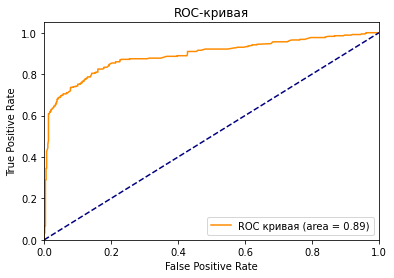

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score

clf = SVC(C=1.5, random_state=42, probability=True).fit(X_train, y_train)
prob = clf.predict_proba(X_train)[:,1]
fpr, tpr, treshold = roc_curve(y_train, prob)

plt.plot(fpr, tpr,  color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc_score(y_train, prob))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Валидация и загрузка на kaggle - итоговая accuracy - 0.78229 (2797ое место на лидерборде; ниже небольшой разбор лидерборда)

In [4]:
test = pd.read_csv('test.csv', index_col='PassengerId')
test['Age'] = age_imputer.transform(test['Age'].values.reshape(-1, 1))
test_plus = feat_plus.transform(test)

X_test = prep_pipe.transform(test_plus)

X_test = np.concatenate((X_test, test_plus[plus].values), axis=1)

svc_best = SVC(C=1.5, random_state=42).fit(X_train, y_train)
y_pred = svc_best.predict(X_test)

y_pred_df = pd.DataFrame(data=list(zip(test.index, y_pred)), columns=['PassengerId', 'Survived'])
y_pred_df.to_csv('submission.csv', sep=',', index=False)

In [2]:
df = pd.read_csv('titanic-publicleaderboard.csv')
df.head()

,TeamId,TeamName,SubmissionDate,Score
0,3095236,Muhi,2021-07-28 13:50:47,1.0
1,6362628,takumi ForGoogleClab,2021-07-28 14:15:27,1.0
2,7107359,Rziting,2021-07-30 09:45:11,1.0
3,7159999,Goenks,2021-07-30 05:31:52,1.0
4,7146643,Zalik,2021-07-30 10:00:34,1.0


In [8]:
df['score_groups'] = pd.cut(df.Score, (-1, 0.5, 0.7, 0.8, 0.9, 1))

In [10]:
df.groupby('score_groups').TeamName.count()

score_groups
(-1.0, 0.5]      210
(0.5, 0.7]       965
(0.7, 0.8]     48642
(0.8, 0.9]       300
(0.9, 1.0]       168
Name: TeamName, dtype: int64

In [25]:
df.query('Score != 1').Score.max()

0.9976

In [23]:
len(df.query('Score == 1.0'))

149

In [17]:
df_most = df.query('Score >= 0.7 & Score <= 0.8')

In [20]:
df_most['score_groups'] = pd.cut(df_most.Score, 5)
df_most.groupby('score_groups').TeamName.count()

<ipython-input-20-ab9936652061>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_most['score_groups'] = pd.cut(df_most.Score, 5)


score_groups
(0.701, 0.721]      289
(0.721, 0.74]       368
(0.74, 0.76]       1085
(0.76, 0.779]     43874
(0.779, 0.799]     3026
Name: TeamName, dtype: int64